In [1]:
import numpy as np
import pandas as pd
#import torch
#import torch.nn as nn
#import torch.optim as optim
from tqdm import tqdm
#from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical

from sklearn.feature_extraction.text import TfidfVectorizer

# Packages for modeling
from keras.models import Sequential
from keras.layers import Dense

**Loading our tokens**

In [2]:
tweets_train_tokenized = pd.read_csv('csvs/tweets_train_tokens.csv', index_col=False)
tweets_train_tokenized_message = pd.Series(tweets_train_tokenized.message)
# Converting Panda series into Unicode datatype as required by vectorizers
tweets = tweets_train_tokenized_message.astype('U').values
tweets

array(['arirang simply kpop kim hyung jun cross ha yeong playback',
       'read politico article donald trump running mate tom brady list likely choice',
       'type bazura project google image image photo dad glenn moustache whatthe',
       ..., 'bring dunkin iced coffee tomorrow hero',
       'currently holiday portugal come home tomorrow poland tuesday holocaust memorial trip',
       'ladykiller saturday aternoon'], dtype=object)

**Loading our tweets targets**

In [3]:
tweets_train_y = pd.read_csv('csvs/tweets_train_y.csv', index_col=False)
tweets_train_y = pd.Series(tweets_train_y['0'])
tweets_train_y = tweets_train_y.values
tweets_train_y

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [4]:
NB_START_EPOCHS = 10  # Number of epochs we usually start to train with
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent

In [5]:
import tensorflow as tf
import keras.backend as K

"""
def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    # tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)
"""
def deep_model(model, X_train, y_train, X_valid, y_valid):
    '''
    Function to train a multi-class model. The number of epochs and 
    batch_size are set by the constants at the top of the
    notebook. 
    
    Parameters:
        model : model with the chosen architecture
        X_train : training features
        y_train : training target
        X_valid : validation features
        Y_valid : validation target
    Output:
        model training history
    '''
    model.compile(optimizer='adam'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
    
    history = model.fit(X_train
                       , y_train
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=0)
    return history

def eval_metric(history, metric_name):
    '''
    Function to evaluate a trained model on a chosen metric. 
    Training and validation metric are plotted in a
    line chart for each epoch.
    
    Parameters:
        history : model training history
        metric_name : loss or accuracy, f1
    Output:
        line chart with epochs of x-axis and metric on
        y-axis
    '''
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()

In [6]:
def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
    '''
    Function to test the model on new data after training it
    on the full training data with the optimal number of epochs.
    
    Parameters:
        model : trained model
        X_train : training features
        y_train : training target
        X_test : test features
        y_test : test target
        epochs : optimal number of epochs
    Output:
        test accuracy and test loss
    '''
    model.fit(X_train
              , y_train
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_test, y_test)
    
    return results

**Train-test split**

In [7]:
X_train, X_test, y_train, y_test = train_test_split(tweets, tweets_train_y, test_size=0.2, random_state=37)
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

# Train data samples: 39740
# Test data samples: 9935


**Converting target classses to numbers**

In [8]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)
y_train_oh.shape

(39740, 3)

**Text to Vectors Using TfidfVectorizer**

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer

# you can also specify ngram_range
# you can also choose the max_features parameter, which just includes those features with the top frequencies specified by the max_features i.e.
# max_features = 7500, includes only those top 7500 features with the highest frequencies
# min_df includes only words which appear at least twice in every document
# ngram_range=(1,2)
tfidf = TfidfVectorizer(min_df =2, max_features=7500, ngram_range=(1,2))
X_train_seq = tfidf.fit_transform(X_train).toarray()
X_train_seq

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [10]:
X_test_seq = tfidf.transform(X_test).toarray()
X_test_seq

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

**Splitting off validation data**

In [11]:
X_train_emb, X_valid_emb, y_train_emb, y_valid_emb = train_test_split(X_train_seq, y_train_oh, test_size=0.2, random_state=37)

assert X_valid_emb.shape[0] == y_valid_emb.shape[0]
assert X_train_emb.shape[0] == y_train_emb.shape[0]

print('Shape of validation set:',X_valid_emb.shape)

Shape of validation set: (7948, 7500)


In [12]:
X_train_emb.shape

(31792, 7500)

In [13]:
X_valid_emb.shape

(7948, 7500)

In [14]:
y_train_emb.shape

(31792, 3)

**Modeling**

In [15]:
y_valid_emb.shape

(7948, 3)

In [16]:
emb_model = Sequential()
emb_model.add(Dense(55, input_dim =7500, activation='relu'))
#emb_model.add(Dense(1000, activation='relu'))
#emb_model.add(Dense(100, activation='relu'))
#emb_model.add(Dense(5, activation='relu'))
emb_model.add(Dense(5, activation='relu'))
emb_model.add(Dense(3, activation='softmax'))
emb_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 55)                412555    
                                                                 
 dense_1 (Dense)             (None, 5)                 280       
                                                                 
 dense_2 (Dense)             (None, 3)                 18        
                                                                 
Total params: 412,853
Trainable params: 412,853
Non-trainable params: 0
_________________________________________________________________


In [17]:
emb_history = deep_model(emb_model, X_train_emb, y_train_emb, X_valid_emb, y_valid_emb)
emb_history.history['accuracy'][-1]

0.7883115410804749

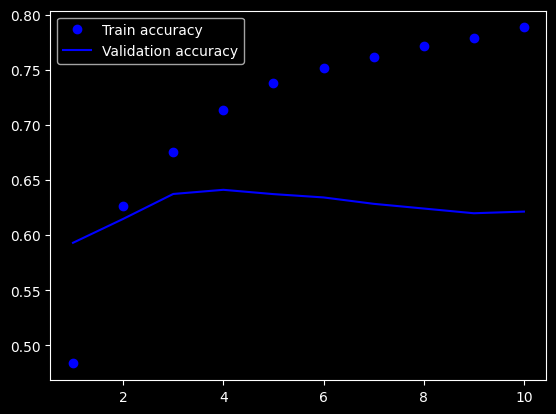

In [18]:
eval_metric(emb_history, 'accuracy')

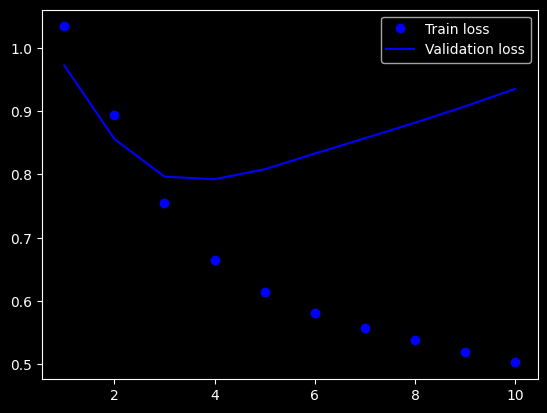

In [19]:
eval_metric(emb_history, 'loss')

In [20]:
def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
    '''
    Function to test the model on new data after training it
    on the full training data with the optimal number of epochs.
    
    Parameters:
        model : trained model
        X_train : training features
        y_train : training target
        X_test : test features
        y_test : test target
        epochs : optimal number of epochs
    Output:
        test accuracy and test loss
    '''
    model.fit(X_train
              , y_train
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_test, y_test)
    
    return results

In [21]:
emb_results = test_model(emb_model, X_train_seq, y_train_oh, X_test_seq, y_test_oh, 6)
print('/n')
print('Test accuracy of word embeddings model: {0:.2f}%'.format(emb_results[1]*100))

311/311 [==============================] - 1s 3ms/step - loss: 0.9457 - accuracy: 0.6206
/n
Test accuracy of word embeddings model: 62.06%


In [22]:
def baseline_model():
    model = Sequential()
    model.add(Dense(55, input_dim =7500, activation='relu'))
    #model.add(Dense(1000, activation='relu'))
    #model.add(Dense(100, activation='relu'))
    #model.add(Dense(5, activation='relu'))
    model.add(Dense(5, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model
    

In [23]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [24]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=100, verbose=0)
kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X_train_emb, y_train_emb, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

C:\Users\acer\AppData\Local\Temp\ipykernel_20580\723716869.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=100, verbose=0)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 55)                412555    
                                                                 
 dense_4 (Dense)             (None, 5)                 280       
                                                                 
 dense_5 (Dense)             (None, 3)                 18        
                                                                 
Total params: 412,853
Trainable params: 412,853
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 55)                412555    
                                                                 
 dense_7 (Dense)          

KeyboardInterrupt: 